# Vector Autoregression

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [229]:
df = pd.read_csv('../data/macroecon.csv')
df = df[['Investment','FedSpend']]
df.head()

,Investment,FedSpend
0,47.202,38.915
1,50.336,39.904
2,52.516,42.739
3,51.334,44.051
4,43.140,45.908


In [234]:
#Augmented Dickey Fuller test for stationarity 
#H0: Time series contains a unit root and is non-stationary, HA: Time series does not contain a unit root and is stationary
#If adf_stat < adf_cv, reject the null / If p-value < alpha, reject the null
   
def adf_test(values, alpha):
    adf_result = adfuller(values)
    adf_p_value = adf_result[1]
    
    if adf_p_value < alpha:
        print('Reject the Null - The data are probably stationary')
    elif adf_p_value > alpha:
        print('Do not reject the null - The data are probably not stationary.')   
        
#adf_test(df['Productivity'], 0.05)
adf_test(df['Investment'], 0.05)
adf_test(df['FedSpend'], 0.05)

Do not reject the null - The data are probably not stationary.
Do not reject the null - The data are probably not stationary.


In [236]:
#Differencing
df_d1 = df.diff()
df_d1 = df_d1.dropna()

#adf_test(df_d1['Productivity'], 0.05)
adf_test(df_d1['Investment'], 0.05)
adf_test(df_d1['FedSpend'], 0.05)

Reject the Null - The data are probably stationary
Reject the Null - The data are probably stationary


In [151]:
#Split into training and testing sets
#train_size = int(len(df_d1) * 0.8)
#train, test = df_d1[:train_size], df_d1[train_size:]

In [238]:
#Fit the Vector Autoregression Model
model = VAR(df_d1)
results = model.fit(maxlags=7, ic='aic')
results.summary()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Jun, 2024
Time:                     14:06:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    18.9091
Nobs:                     297.000    HQIC:                   18.6854
Log likelihood:          -3565.45    FPE:                1.12246e+08
AIC:                      18.5360    Det(Omega_mle):     1.01712e+08
--------------------------------------------------------------------
Results for equation Investment
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -3.222659         3.812703           -0.845           0.398
L1.Investment         0.475471         0.071725            6.629           0.000
L1.FedSpend           0.211120         0.016624        

In [264]:
#20 period forecast
lag_order = results.k_ar
forecast_diff = results.forecast(df_d1.values[-lag_order:], steps=20)  
forecast_diff

array([[  64.75823274,   -7.32207002],
       [  30.22628159,   33.41448318],
       [  64.84117276,  -88.22813662],
       [  22.21800789,   52.62754927],
       [  34.17030356,  101.7988192 ],
       [  55.62654099, -106.59770815],
       [  37.08407438,   38.52626759],
       [  24.36507908,   85.50480487],
       [  22.98377965,   -9.1247905 ],
       [  20.81599106,   38.73409291],
       [  27.9690321 ,   24.43453452],
       [  20.93307553,   26.96870499],
       [  19.99198491,   37.14151669],
       [  25.87984326,   16.06327217],
       [  24.47599579,   23.35959349],
       [  22.24132426,   17.23223921],
       [  21.65401729,   19.54661077],
       [  19.82991102,   29.91293337],
       [  21.96433377,   12.79733486],
       [  21.18171821,   17.14758049]])

In [268]:
#Invert the differencing to get the forecast in the original scale
def invert_diff(original, diff_values):
    return original + np.cumsum(diff_values)

forecast_inverted = pd.DataFrame({col: invert_diff(df[col].iloc[-1], forecast_diff[:, idx]) for idx, col in enumerate(df.columns)}, index=range(1, 21))
forecast_inverted

,Investment,FedSpend
1,5069.177233,6590.130930
2,5099.403514,6623.545413
3,5164.244687,6535.317277
4,5186.462695,6587.944826
5,5220.632999,6689.743645
6,5276.259540,6583.145937
7,5313.343614,6621.672204
8,5337.708693,6707.177009
9,5360.692473,6698.052219
10,5381.508464,6736.786312


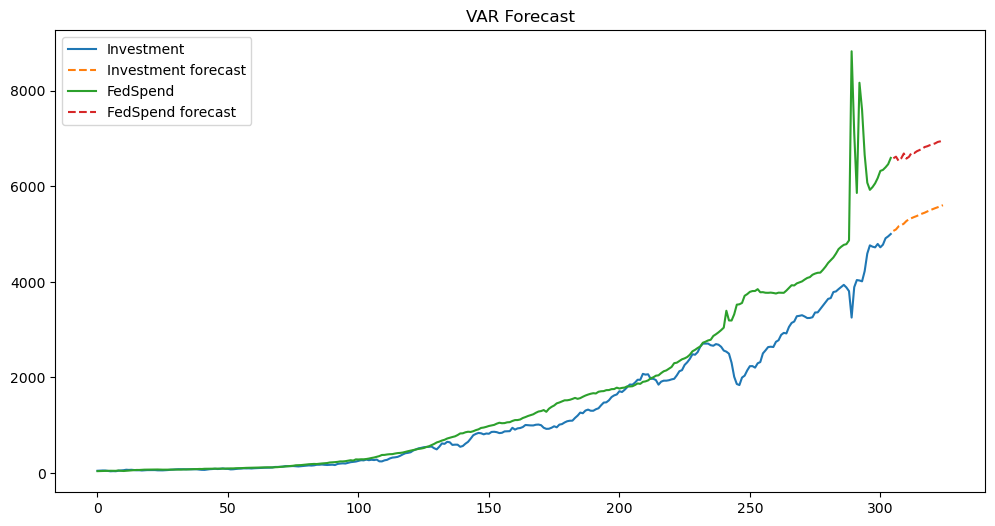

In [270]:
#Plotting the original series and the forecast
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df[col], label=col)
    plt.plot(range(len(df), len(df) + len(forecast_inverted)), forecast_inverted[col], linestyle='--', label=f'{col} forecast')
plt.title('VAR Forecast')
plt.legend()
plt.show()

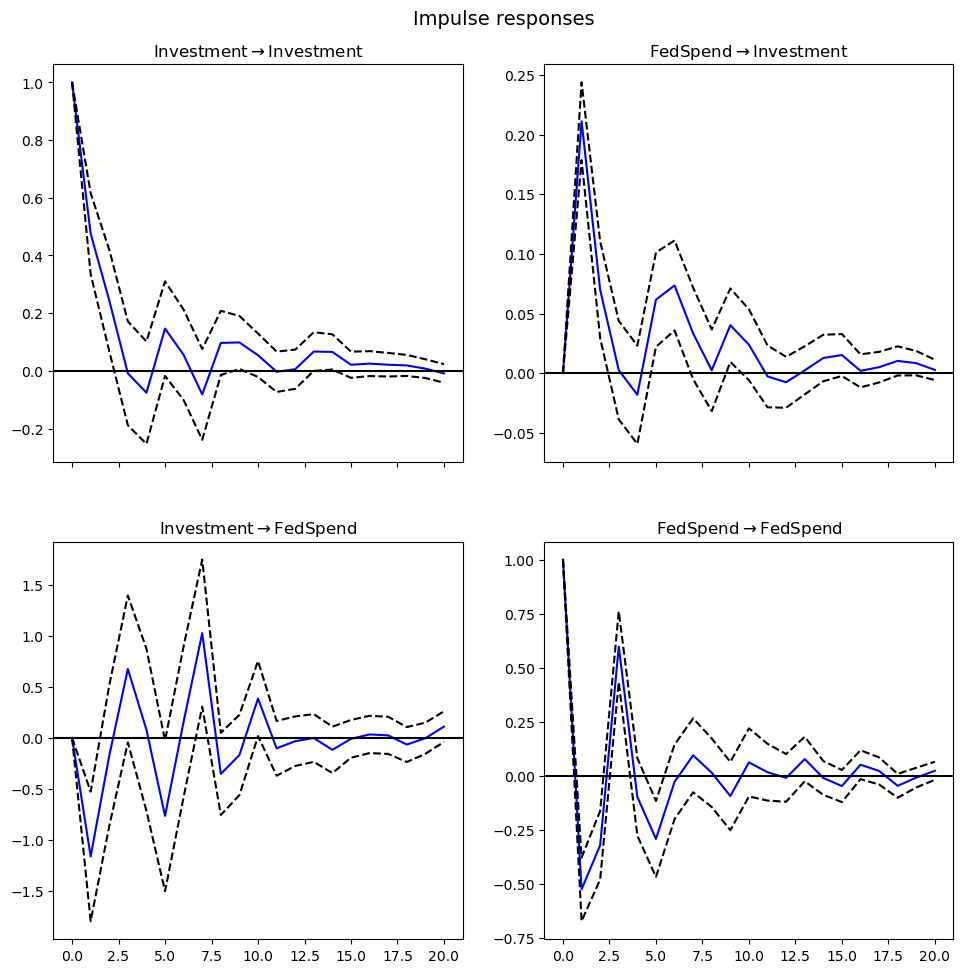

In [288]:
#20 period impulse response function
#help(irf)
irf = results.irf(20)  
irf.plot(orth=False); #Semicolon removes dupicate graphs?